---

title: **U-NET Base** Training Script

author: Tiago Ribeiro

date: 23/11/2022

---

### 📚 Libraries

In [1]:
'~~ generic use libraries ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'
import base64                          # decoding of base64 data
import json                            # manipulation of JSON files
import io                              # input and output stream operations
import os                              # interface with various operating systems
import glob                            # finding file paths
import numpy as np                     # mathematical and matrix operations
import matplotlib.pyplot as plt        # generating plots
import matplotlib.gridspec as gridspec # configuring grid of plots
from datetime import datetime          # manipulating dates and time
from psutil import virtual_memory      # memory usage
'~~ image manipulation ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'
from PIL import ImageDraw, Image       # image manipulation
import cv2                             # computer vision and image manipulation
'~~ machine learning ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~'
import tensorflow as tf                   # machine learning models
from keras import backend                 # Keras low-level configurations
from sklearn.model_selection import KFold # cross-validation
'fully convolutional network layers'
from tensorflow.keras.layers import (Conv2DTranspose, Conv2D, SeparableConv2D)
from tensorflow.keras.layers import (Activation, MaxPooling2D, Concatenate)
'cost functions'
from tensorflow.keras.losses import BinaryCrossentropy  # binary cross-entropy
'metrics'
from tensorflow.keras.metrics import MeanIoU            # Jaccard index
from tensorflow.keras.metrics import Precision 
from tensorflow.keras.metrics import Recall 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import f1_score 
'optimizers'
from tensorflow.keras.optimizers import Adam         # adaptive moment estimation opt.
'other'
from tensorflow.keras import Input                   # model input
from sklearn.model_selection import train_test_split # split dataset

In [2]:
print(tf. __version__)

2.10.1


### 🏿 GPU and CUDA Configurations

In [3]:
gpu = !nvidia-smi --query-gpu=gpu_name --format=csv,noheader
ram_gb = virtual_memory().total / 1e9
print(f'{gpu.s} with {round(ram_gb,1)} GB available RAM.')
!nvcc --version

NVIDIA GeForce RTX 3090 with 34.2 GB available RAM.
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_22:08:44_Pacific_Standard_Time_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


### ⚙️ Model Configurations

In [4]:
CONFIGS = dict(
    W = 256,                # width
    H = 256,                # height
    C = 3,                  # image R,G,B channels 
    BATCH_SZ = 2,           # batch size
    REF_FILTERS = 128,      # reference number for U-NET filters
    F_INIT = "he_normal",   # Kaiming He initialization
    CLASS_NUM = 1,        
    EPOCHS = 100,           # training epochs
    OPTIMIZER = Adam(learning_rate=0.001), 
    COST_F = BinaryCrossentropy,              
    CONV_ACTIV = Activation(tf.nn.relu),    # rectified linear unit activation function
    METRICS = [MeanIoU(num_classes = 2, name='iou'),
               Precision(thresholds=0.5), 
               Recall(thresholds=0.5)], 
    SEED = 42,                              # random seed
    DTYPE = np.float32                      # data type
)

# forces channel-last order (L,A,C)
backend.set_image_data_format('channels_last')

### 📁 Data source paths and directories creation

**note**: to test on your own machine, please set up the paths

In [5]:
DIR = os.getcwd() # returns the current working directory
DATASET_DIR = 'G:\\O meu disco\\BolsaInvestigacao\\'

# JSON files directories and video file path
JSON_DIR = os.path.join(DATASET_DIR, 'datasets\\fogos\\anotacoes_json')
JSON_DIR_TEST = os.path.join(DATASET_DIR, 'datasets\\fogos\\anotacoes_json_teste')
VIDEO_DIR = os.path.join(DATASET_DIR, 'datasets\\fogos\\v2_2_0019_20_21_22.mp4')

# dataset directories
IMGS_DIR_TRAIN = os.path.join(DIR, "data\\imgs_train")
MSKS_DIR_TRAIN = os.path.join(DIR, "data\\mscs_train")
IMGS_DIR_TEST = os.path.join(DIR, "data\\imgs_test")
MSKS_DIR_TEST = os.path.join(DIR, "data\\mscs_test")
# directory to save model-generated segmentations and respective frames
FRAMES_DIR = os.path.join(DIR, "data\\frames")
SEGS_DIR = os.path.join(DIR, "data\\segs")
# directory to save models and logs
CHECKPOINT_MODELOS = os.path.join(DIR, "data\\modelos")
LOGS_MODELOS = os.path.join(DIR, "data\\logs")

output_folders = [FRAMES_DIR, SEGS_DIR, CHECKPOINT_MODELOS, LOGS_MODELOS]

# create folders
for folder in output_folders:
    if not os.path.exists(folder):
        os.makedirs(folder)

### 🗃️ Auxiliary Functions

#### callback_funcs

In [22]:
def callback_funcs(str_run, monitor_metric='val_iou', mode='min', reduce_factor=0.5,
                   reduce_patience=10, fold_n = 0,  additional_callbacks=[]):
    """
    Creates a list of Keras callbacks to be used during model training.

    Parameters
    ----------
    str_run : str
        Prefix for the filenames of the CSVLogger and ModelCheckpoint callbacks.
    monitor_metric : str, optional
        Name of the metric to monitor for the ReduceLROnPlateau and ModelCheckpoint callbacks. 
        Default is 'loss'.
    mode : str, optional
        One of {'min', 'max', 'auto'}. 
        Specifies whether the monitored metric should be minimized, maximized, or inferred automatically for the ModelCheckpoint callback. 
        Default is 'min'.
    reduce_factor : float, optional
        Factor by which to reduce the learning rate when there is no improvement in monitored metric after reduce_patience epochs.
        Default is 0.5.
    reduce_patience : int, optional
        Number of epochs with no improvement after which to reduce the learning rate for the ReduceLROnPlateau callback.
        Default is 10.
    additional_callbacks : list, optional
        List of additional Keras callbacks to be added to the output list.
        Default is [].

    Returns
    -------
    list
        A list of Keras callbacks to be used during model training.

    """   

    # Learning Schedule
    # Reduce learning rate when there is no improvement in monitored metric after a certain number of epochs
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor=monitor_metric,
        factor=reduce_factor,
        mode=mode,
        patience=reduce_patience,
        verbose=1,
        min_lr=1e-6)
    
    # Training Logs
    # Log training metrics to a CSV file
    csv_logger = tf.keras.callbacks.CSVLogger(
        os.path.join(LOGS_MODELOS, str_run + '.csv'),
        separator=",",
        append=True)
    
    # Model Checkpoint
    # Save the best model based on monitored metric on validation data
    checkpoint_filepath = os.path.join(CHECKPOINT_MODELOS, str_run +'_epoch_{epoch:02d}.h5')
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_best_only=True,
        mode=mode,
        verbose=1,
        monitor=monitor_metric)
    
    callbacks = [csv_logger, reduce_lr, checkpoint] + additional_callbacks
    
    return callbacks

#### create_run_string

In [7]:
def create_run_string(model_name = "NN", fold=None, use_cross_val=False):
    """Create a string for each training run.

    Args:
        model_name: (str,optional): the designation of the model. Defaults to "NN".
        fold (int, optional): The fold number for cross-validation. Defaults to None.
        use_cross_val (bool, optional): Whether or not to use cross-validation. Defaults to False.

    Returns:
        str: The string for the training run.
    """
    now = datetime.now()
    dt_string = now.strftime("%d_%b_%Hh%Mmin")
    str_run = f"{model_name}_{CONFIGS['W']}x{CONFIGS['H']}_F_NUM_{CONFIGS['REF_FILTERS']}_DT_{dt_string}"
    if use_cross_val:
        str_run += f"_fold_{fold}"
    return str_run

#### metrics_graphs

In [8]:
def metrics_graphs(history, model, model_conf = "not provided!", iou = False, y_log = False):
    """
    Plots training and validation metrics (accuracy, loss, and IoU) of a Keras model during training.
    Parameters:
    -----------
    history: tf.keras.callbacks.History
        Object returned by model.fit() containing training history.
    model: tf.keras.Model
        The trained machine learning model.
    conf_modelo: str, optional (default="")
        The configuration of the model (optional)
    iou: bool, optional (default=False)
        Whether to plot the IoU score or not. If True, the function plots the IoU score over the epochs.
    y_log: bool, optional(default=False) 
        Whether to use logarithmic scale for the y-axis on the loss plot. Defaults to False.
    """
    
    if not isinstance(history, tf.keras.callbacks.History):
        raise TypeError("The 'history' argument must be a tf.keras.callbacks.History object.")
    if not isinstance(model, tf.keras.Model):
        raise TypeError("The 'model' argument must be a tf.keras.Model object.")
    if not isinstance(model_conf, str):
        raise TypeError("The 'model_conf' argument must be a string.")
        
    plt.style.use('fast') 

    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,8))
    
    if iou:
        if 'iou' not in history.history or 'val_iou' not in history.history:
            raise ValueError("IoU score not found in the history object.")
        
        ax1.plot(np.array(history.history['iou']) * 100, "limegreen", marker=".")
        ax1.plot(np.array(history.history['val_iou']) * 100, "orangered", marker=".")
        ax1.set_title('Intersection over Union (IoU) of ' + model.name + '\n' + "Configuration: " + model_conf)
        ax1.set_ylabel('IoU (%)')
        ax1.set_xlabel('Epoch')
        ax1.legend(['train', 'validation'], loc='best')
        ax1.grid(linestyle='--', linewidth=0.4)
        
        # Creates box indicating maximum validation IoU
        xmax = np.argmax(history.history['val_iou'])
        ymax = max(history.history['val_iou']) * 100
        text = "IoU Val.:{:.3f} %".format(ymax)
        bbox_props = dict(boxstyle="round,pad=0.3", fc="w", ec="k", lw=0.5)   
        arrowprops1 = dict(arrowstyle="->",connectionstyle="arc3,rad=0.3")
        kw = dict(xycoords='data',textcoords="offset points",
                  arrowprops=arrowprops1, bbox=bbox_props, ha="right", va="center")
        ax1.annotate(text, xy=(xmax, ymax), xytext=(-15,-30), **kw)
        ax1.set_ylim(top=max(history.history['val_iou'] + 
                             history.history['iou']) * 100 + 1)
    else:
        if 'accuracy' not in history.history or 'val_accuracy' not in history.history:
            raise ValueError("Accuracy not found in the history object.")
        
        
        ax1.plot(np.array(history.history['accuracy'])*100,"limegreen",  marker =".")
        ax1.plot(np.array(history.history['val_accuracy'])*100, "orangered" ,  marker =".")
        ax1.set_title('Accuracy of ' + model.name + '\n' + "Configuration: " + model_conf)
        ax1.set_ylabel('Accuracy (%)')
        ax1.set_xlabel('Epoch')
        ax1.legend(['train', 'validation'], loc='best')
        ax1.grid(linestyle='--', linewidth=0.4)

        # Creates box indicating maximum validation accuracy
        xmax = np.argmax(history.history['val_accuracy'])
        ymax = max(history.history['val_accuracy'])*100
        text= "Acur. Val.:{:.3f} %".format(ymax)
        # lw, linewidth; fc, facebolor; ec, edgecolor
        bbox_props = dict(boxstyle="round,pad=0.3", fc="w", ec="k", lw=0.5)   
        arrowprops1 = dict(arrowstyle="->",connectionstyle="arc3,rad=0.3")
        kw = dict(xycoords='data',textcoords="offset points",
                  arrowprops=arrowprops1, bbox=bbox_props, ha="right", va="center")
        ax1.annotate(text, xy=(xmax, ymax), xytext=(-15,-30), **kw)
        ax1.set_ylim(top = max(history.history['val_accuracy'] + 
                               history.history['accuracy'])*100 + 1)  
    
    # Plots Cost Graph
    ax2.plot(history.history['loss'], "limegreen",  marker =".")
    ax2.plot(history.history['val_loss'],"orangered" ,  marker =".")
    ax2.set_title('Cost of '+ model.name +'\n'+ "Configuration: " + model_conf)
    ax2.set_ylabel('Cost')
    ax2.set_xlabel('Epoch')
    ax2.legend(['train', 'validation'], loc='best')
    ax2.grid(linestyle = '--', linewidth = 0.5)
    ax2.set_ylim(ymin=0)
    if y_log == True:
        ax2.set_yscale('log')
        ax2.set_ylim(None)
    
    # Creates box indicating minimum validation cost value
    xmin = np.argmin(history.history['val_loss'])
    ymin = min(history.history['val_loss'])
    text2= "Val. Cost:{:.3f}".format(ymin)
    bbox_props2 = dict(boxstyle="round,pad=0.3", fc="w", ec="k", lw = 0.5)
    arrowprops2 = dict(arrowstyle="->",connectionstyle="arc3,rad=-0.3")
    kw2 = dict(xycoords='data',textcoords="offset points",
                arrowprops=arrowprops2, bbox=bbox_props2, ha="right", va="center")
    ax2.annotate(text2, xy=(xmin, ymin), xytext=(70, 35), **kw2)
        
    plt.tight_layout()

#### preprocess_img & preprocess_msk

In [9]:
def preprocess_msk(msc, transp=False):
    """
    Reads an image and converts it to grayscale (1 channel) and binarizes it 
    with a threshold of 127.5.

    Args:
        msc (str): Path to the image file.
        transp (bool): Whether to transpose the output array or not. 
            Defaults to False.

    Returns:
        numpy.array: An array of shape (Channels, Width, Height) if 
        transp is False, or an array of shape (Width, Height, Channels)
        if transp is True.
    """
    # binarize the mask
    msc = (cv2.imread(msc, cv2.IMREAD_GRAYSCALE) > 127.5) * 1
    if not transp:
        msc = msc[..., np.newaxis]
    else:
        msc = msc[..., np.newaxis].transpose(2, 0, 1)
    return msc

def preprocess_img(img, transp=False):
    """
    Reads an image and normalizes it by dividing by 255. 
    It also changes the order of the image tensor from (L, A, C) to (C, L, A).

    Args:
    img (str): The path to the image file.
    transp (bool): A flag to indicate if the image tensor should be transposed. 
                   Default is False.

    Returns:
    numpy.array: The preprocessed image as a numpy array of shape (Channels, Width, Height).
    """
    # Read image in RGB format (not BGR!)
    img = cv2.imread(img)[..., ::-1] / 255

    if transp:
        img = img.transpose(2, 0, 1)

    return img

#### polygons_to_mask

In [10]:
def polygons_to_mask(img_shape, polygons):
    """
    Converts a list of polygons into a binary mask of the given shape.

    Args:
        img_shape (tuple): The shape of the output mask.
        polygons (list): A list of polygons, each represented as a list of (x, y) coordinates.

    Returns:
        A binary mask of shape `img_shape` where the pixels inside the polygons are set to True (1) and pixels outside are set to False (0).

    source: https://github.com/Jeff-sjtu/labelKeypoint/blob/master/labelme/utils.py
    """
    mask = np.zeros(img_shape[:2], dtype=np.uint8)
    mask = Image.fromarray(mask)
    xy = list(map(tuple, polygons))
    ImageDraw.Draw(mask).polygon(xy=xy, outline=1, fill=1)
    mask = np.array(mask, dtype=bool)
    
    return mask

#### labelme_shapes_to_label

In [11]:
def labelme_shapes_to_label(img_shape, shapes):
    """
    Convert a list of shapes in Labelme format to a label array and label names.

    Parameters:
        img_shape (tuple): A tuple containing the shape of the original image (height, width, channels).
        shapes (list): A list of shape dictionaries in Labelme format, each with 'label' and 'points' keys.

    Returns:
        tuple: A tuple containing:
            - lbl (numpy.ndarray): A 2D integer array of shape (height, width), where each pixel contains
              the corresponding label value. Background pixels are labeled as 0.
            - lbl_names (list): A list of label names, where lbl_names[i] corresponds to label value i.

    Source:
        https://github.com/Jeff-sjtu/labelKeypoint/blob/master/labelme/utils.py
    """

    label_name_to_val = {'background': 0}
    lbl = np.zeros(img_shape[:2], dtype=np.int32)
    for shape in shapes:
        polygons = shape['points']
        label_name = shape['label']
        if label_name in label_name_to_val:
            label_value = label_name_to_val[label_name]
        else:
            label_value = len(label_name_to_val)
            label_name_to_val[label_name] = label_value
        mask = polygons_to_mask(img_shape[:2], polygons)
        lbl[mask] = label_value

    lbl_names = [None] * (max(label_name_to_val.values()) + 1)
    for label_name, label_value in label_name_to_val.items():
        lbl_names[label_value] = label_name
        
    return lbl, lbl_names

#### split_data

In [12]:
def split_data(imgs_array, mascs_array, train_portion = 0.9, seed = CONFIGS["SEED"], shuffle = False, verbose = True):
    """
    Splits images and masks into train, validation, and test sets.

    Parameters:
        imgs_array (list): List of images.
        mascs_array (list): List of masks.
        train_portion (float): Proportion of data to use for training (0 < train_portion < 1).
        seed (int): Seed to use for random number generator to ensure reproducibility of the same data split.
        shuffle (bool): Whether to shuffle the data before splitting.
        verbose (bool): Whether to print summary statistics of the data split.

    Returns:
        Tuple of arrays with images for train, validation, and test sets (X_train, X_val, X_test), 
        and arrays with masks for train, validation, and test sets (Y_train, Y_val, Y_test).

    Example:
        If train_portion=0.9, the data will be split into 72% train / 18% validation / 10% test.
    """

    if not 0 <= train_portion <= 1:
        raise ValueError("train_portion must be between 0 and 1")

    # assert train_portion >= 0 and train_portion <= 1, "Fracão de treino inválida"
  
    if not shuffle:
        seed = None

    X_tmp, X_test, Y_tmp, Y_test = train_test_split(imgs_array, 
                                                    mascs_array, 
                                                    train_size = train_portion, 
                                                    random_state = seed,
                                                    shuffle = shuffle )

    X_tr, X_val, Y_tr, Y_val = train_test_split(X_tmp, 
                                                Y_tmp, 
                                                train_size = 0.8, 
                                                random_state = seed,
                                                shuffle = shuffle )

    if verbose:
        print(f" Training set ({round((len(X_tr)/len(imgs_array))*100)}%): {len(X_tr)} images and {len(Y_tr)} masks")
        print(f" Validation set ({round((len(X_val)/len(imgs_array))*100)}%): {len(X_val)} images and {len(Y_val)} masks")
        print(f" Teste set ({round((len(X_test)/len(imgs_array))*100)}%): {len(X_test)} images and {len(Y_test)} masks")

    return X_tr, X_val, X_test, Y_tr, Y_val, Y_test

#### generate_batch

In [13]:
def generate_batch(data, batch_size, unitary_batch=False):
    """
    Generates batches of data with size equal to `batch_size`. The last batch is discarded
    to prevent compatibility issues with the output data format.

    Args:
        data (list of lists): Input data, where the first list contains images and the second list
                              contains masks.
        batch_size (int): The size of each batch.
        unitary_batch (bool, optional): If True, generates a single batch for sanity check. Defaults to False.

    Yields:
        tuple of numpy arrays: A generator of batches that produces X and y, where X is a numpy array of
                               'batch_size' sequences of images and y is a numpy array of 'batch_size'
                               sequences of masks.

    Raises:
        Exception: If an error occurs during image preprocessing.

    """
    # Convert list of lists to numpy array
    data = np.array(data)

    if unitary_batch:
        sample_num = 2 * batch_size
    else: 
        sample_num = len(data[0])

    while True:
        # Discard last batch
        for offset in range(0, sample_num - batch_size, batch_size):
            imgs_lote = data[0, offset: offset + batch_size]
            masc_lote = data[1, offset: offset + batch_size]

            X, y = list(), list()

            # For each batch:
            for img, msk in zip(imgs_lote, masc_lote):
                try:
                    # Preprocess images and masks
                    img = preprocess_img(img)
                    msk = preprocess_msk(msk)
                    X.append(img)
                    y.append(msk)
                except Exception as e:
                    raise Exception(f'Error {e} reading file: {img}')

            # Convert list to numpy array of type float32
            X = np.array(X).astype(np.float32)
            y = np.array(y).astype(np.float32)

            # Yield batch of data
            yield X, y

#### img_b64_to_array

In [14]:
def img_b64_to_array(img_b64):
    """
    The img_b64_to_array function takes a base64 encoded image and returns a 
    numpy array of the decoded image.

    Parameters:
    img_b64 (str): a base64 encoded image.

    Returns:
    img_arr (numpy array): a numpy array representing the decoded image.

    Source: https://github.com/Jeff-sjtu/labelKeypoint/blob/master/labelme/utils.py.
    """
    f = io.BytesIO()
    f.write(base64.b64decode(img_b64))
    img_arr = np.array(Image.open(f))
    return img_arr

#### json2data

In [15]:
def json2data(json_dir, out_dir_imgs, out_dir_msks, img_size=(256, 256)):
    """
    Convert json files created in Labelme to images and masks in *.png format.

    Args:
        json_dir (str): Path to directory containing *.json files.
        out_dir_imgs (str): Destination path for the images.
        out_dir_msks (str): Destination path for the masks.
        img_size (tuple): Size of the output images and masks.

    Raises:
        ValueError: If the dimensions of the image and mask arrays do not match.

    """
    try:
        # create output directory for images
        os.makedirs(out_dir_imgs, exist_ok=True)
        # create output directory for masks
        os.makedirs(out_dir_msks, exist_ok=True)

        # Create a list of all json files in the directory
        files = glob.glob(os.path.join(json_dir, "*.json"))
        print(f"Converting {len(files)} json files...")

        for file in files:
            # Extract data from json file
            data = json.load(open(file))
            # Convert segmentation polygons to mask
            img = img_b64_to_array(data['imageData'])
            # convert segmentation polygons to mask
            msk_l, _ = labelme_shapes_to_label(img.shape, data['shapes'])
            # Resize image and mask
            img = cv2.resize(img, dsize=(img_size[0], img_size[1]), interpolation=cv2.INTER_LINEAR)
            msk = cv2.resize(np.array(msk_l, dtype='uint8'), dsize=(img_size[0], img_size[1]))*255
            # Extract frame index number from filename: 'frame_######
            base = os.path.splitext(os.path.basename(file))[0]
            num_frame = base.split('_')[1]
            # Save image (in RGB mode!!) and mask to *.png file
            cv2.imwrite(os.path.join(out_dir_imgs, base + ".png"), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
            cv2.imwrite(os.path.join(out_dir_msks, 'mask_' + str(num_frame) + ".png"), msk)
        print(f"Conversion completed. {len(files)} images and respective masks were created.")

    except Exception as e:
        print(f"Error converting json files: {e}")

#### rgb_img_analysis

In [16]:
def rgb_img_analysis(image_path, val_unic=False):
    """
    Analyze properties of an image.

    Parameters:
        image_path (str): path to the image file
        val_unic (bool): whether to print unique pixel values (default: False)
        save_figure (bool): whether to save the plotted figure to a file (default: False)
        figure_path (str): path to save the figure (required if save_figure is True)

    Raises:
        FileNotFoundError: if the file at image_path does not exist or cannot be opened
        ValueError: if figure_path is not specified when save_figure is True
    """
    if not os.path.isfile(image_path):
        raise FileNotFoundError(f"No such file: '{image_path}'")

    with open(image_path, "rb") as f:
        img_bytes = f.read()
    img = cv2.imdecode(np.frombuffer(img_bytes, dtype=np.uint8), cv2.IMREAD_COLOR)[..., ::-1]

    if img is None:
        raise ValueError(f"Failed to read image at '{image_path}'")

    print(f"Image with {len(img_bytes)} bytes")
    print(f"Image type: {type(img)}")
    print(f"Image dimensions (height, width, channels): {img.shape}")
    print(f"Pixel value range: [{img.min()}, {img.max()}]")

    if val_unic:
        print(f"Unique pixel values: {np.unique(img)}")

    fig = plt.figure(figsize=(20, 12), constrained_layout=False)
    gs = gridspec.GridSpec(nrows=2, ncols=3)

    # RGB image
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.set_title(f"Image\n'{os.path.basename(image_path)}'")
    ax1.imshow(img)
    ax2 = fig.add_subplot(gs[0, 1:])
    color = ("b", "g", "r")
    for channel, col in enumerate(color):
        histr = cv2.calcHist([img], [channel], None, [256], [0, 256])
        ax2.plot(histr, color=col)
        ax2.set_xlim([0, 256])
        ax2.legend(["Blue", "Green", "Red"])
    ax3 = fig.add_subplot(gs[1, 0])
    ax3.set_title('RED Channel') 
    ax3.set_ylabel('Width {}'.format(img.shape[1])) 
    ax3.set_xlabel('Height {}'.format(img.shape[0])) 
    ax3.imshow(img[ : , : , 0], cmap = 'gray')

    ax4 = fig.add_subplot(gs[1, 1])
    ax4.set_title('GREEN Channel') 
    ax4.set_ylabel('Width {}'.format(img.shape[1])) 
    ax4.set_xlabel('Height {}'.format(img.shape[0])) 
    ax4.imshow(img[ : , : , 1], cmap = 'gray')

    ax5 = fig.add_subplot(gs[1, 2])
    ax5.set_title('BLUE Channel')
    ax5.set_ylabel('Width {}'.format(img.shape[1])) 
    ax5.set_xlabel('Height {}'.format(img.shape[0])) 
    ax5.imshow(img[ : , : , 2], cmap = 'gray')

### ✨ Converting JSON images and masks to PNG

In [ ]:
# Convert JSON files to images and segmentation masks
# training and validation data
json2data(json_dir=JSON_DIR, out_dir_imgs=IMGS_DIR_TRAIN, 
          out_dir_msks=MSKS_DIR_TRAIN, 
          img_size=(CONFIGS['H'], CONFIGS['W']))
# test data      
json2data(json_dir=JSON_DIR_TEST, 
          out_dir_imgs=IMGS_DIR_TEST, 
          out_dir_msks=MSKS_DIR_TEST, 
          img_size=(CONFIGS['H'], CONFIGS['W']))   

Converting 227 json files...
Conversion completed. 227 images and respective masks were created.
Converting 23 json files...
Conversion completed. 23 images and respective masks were created.


In [17]:
# extracts from image and mask file paths
imgs_paths = sorted(glob.glob(IMGS_DIR_TRAIN + '\\*.png'))
msks_paths = sorted(glob.glob(MSKS_DIR_TRAIN + '\\*.png'))
imgs_path_test = sorted(glob.glob(IMGS_DIR_TEST + '\\*.png'))
mscs_path_test = sorted(glob.glob(MSKS_DIR_TEST + '\\*.png'))

### 🔍 Input data visualization (*Sanity Check*)

Image with 153958 bytes
Image type: <class 'numpy.ndarray'>
Image dimensions (height, width, channels): (256, 256, 3)
Pixel value range: [0, 255]


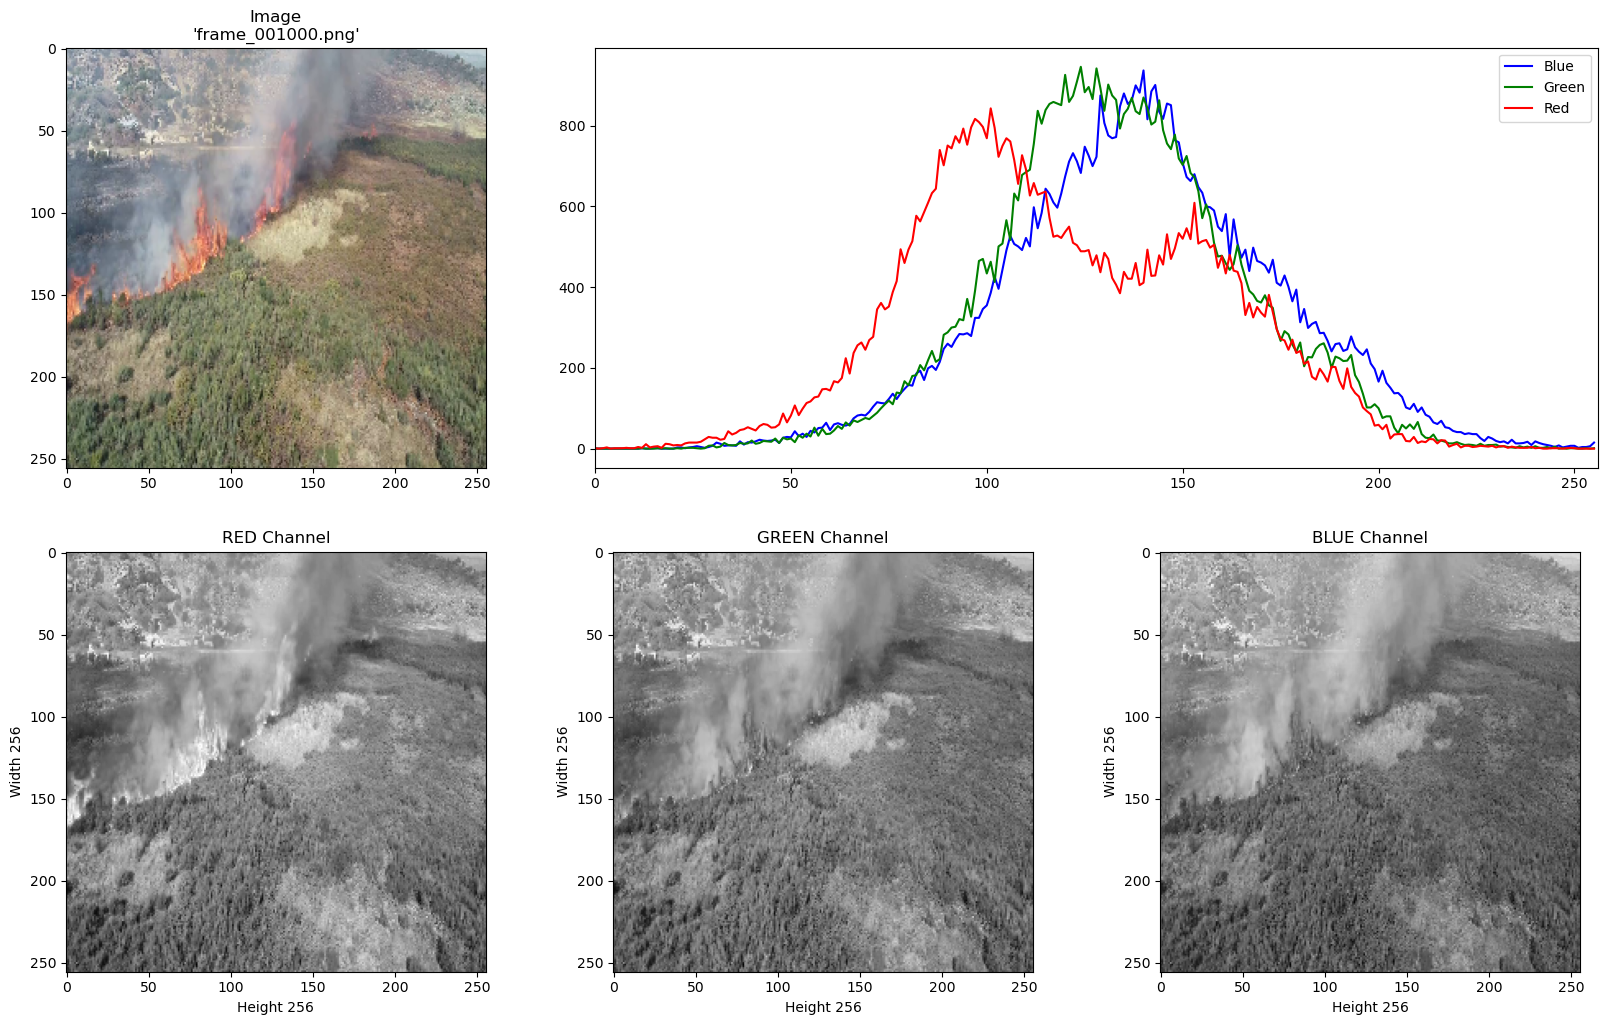

In [18]:
rgb_img_analysis(imgs_paths[10])

### 🔩 Model Definition

#### 📏 **U-NET Base** Dimensions, Layers and Filters
![](assets/UNET_red_table.png)


In [19]:
def conv_block(input, filters, f_init=CONFIGS['F_INIT']):
    """
    Apply two convolutional layers with ReLU activation function.

    Args:
        input (tensor): Input tensor to the block.
        filters (int): Number of filters in the convolutional layers.

    Returns:
        tensor: Output tensor of the block with ReLU activation.
    """
    x = SeparableConv2D(filters, 
                        kernel_size = (3,3), 
                        depthwise_initializer = f_init,
                        pointwise_initializer = f_init,
                        padding="same")(input)
    x = Activation(tf.nn.relu)(x)

    x = SeparableConv2D(filters, 
                        kernel_size = (3,3), 
                        depthwise_initializer = f_init,
                        pointwise_initializer = f_init,
                        padding="same")(x)
    activation = Activation(tf.nn.relu)(x)
    
    return activation

def encoder(input, filters, f_init=CONFIGS['F_INIT']):
    """
    A convolutional block followed by max pooling.

    Args:
        input (tensor): Input tensor.
        filters (int): Number of filters in the convolutional block.
        f_init (str): String indicating the initialization method for filters.
        Default is taken from CONFIGS.

    Returns:
        tuple: Tuple containing the activation map tensor and the output tensor 
        of the max pooling layer.
    """
    # Apply convolutional block
    ativ = conv_block(input, filters, f_init=f_init)
    # Apply max pooling layer
    m_pool = MaxPooling2D(pool_size=(2, 2),
                          strides=2,
                          data_format="channels_last",
                          padding='same')(ativ)
    return ativ, m_pool

def decoder(input, ativ_skip, filters, f_init=CONFIGS['F_INIT']):
    """
    Transposed 2D convolution layer (its output is concatenated with the 
    corresponding encoder activation map), followed by 2 convolutional layers 
    with ReLU activation.

    Args:
        input: input tensor
        ativ_skip: skip connection tensor from the corresponding encoder layer
        filters: number of filters in the convolutional layers

    Returns:
        ativ: tensor containing the output of the decoder layer
    """
    x = Conv2DTranspose(filters, 
                        kernel_size = (3,3), 
                        strides=2,
                        kernel_initializer = f_init,
                        data_format = "channels_last", 
                        padding="same")(input)
    # concatenates activation map with skip connection
    x = Concatenate()([x, ativ_skip])
    ativ = conv_block(x, filters)

    return ativ

#### create_UNET

In [20]:
def create_UNET(img_dim=(256,256), ref_filters=128, num_classes=1, batch_sz=4):
    """
    Creates a U-Net model for image segmentation, with variable input image 
    dimensions and zero padding. This architecture has 4 max pooling layers (2x2) 
    with stride 2 in the contraction phase (encoder), which means that the input 
    image dimensions will be divided by 16 (2^4).

    Args:
        dim_img (tuple, optional): Input image dimensions. Defaults to (256,256).
        ref_filters (int, optional): Number of filters to use in the initial layer. Defaults to 128.
        num_classes (int, optional): Number of classes to classify. Defaults to 1.
        batch_sz (int, optional): Batch size. Defaults to 4.

    Returns:
        tf.keras.Model: The U-Net model.
    """
    # input layer
    input_layer = Input(img_dim + (3,), batch_size=batch_sz)
    # encoder/contraction phase
    activ1, cod1 = encoder(input_layer, ref_filters)
    activ2, cod2 = encoder(cod1, ref_filters * 2)
    activ3, cod3 = encoder(cod2, ref_filters * 4)
    activ4, cod4 = encoder(cod3, ref_filters * 8)
    # bridge
    bridge = conv_block(cod4, ref_filters * 16)
    # decoder/expansion phase
    dec1 = decoder(bridge, activ4, ref_filters * 8)
    dec2 = decoder(dec1, activ3, ref_filters * 4)
    dec3 = decoder(dec2, activ2, ref_filters * 2)
    dec4 = decoder(dec3, activ1, ref_filters)
    # output layer
    if num_classes > 1:
        activ_func = 'softmax'
    else:
        activ_func = 'sigmoid'

    output_layer = Conv2D(num_classes, kernel_size=(1, 1), activation=activ_func,
                          data_format="channels_last", padding="same")(dec4)

    # U-Net model
    unet_model = tf.keras.Model(input_layer, output_layer)
    return unet_model


In [ ]:
model = create_UNET()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(4, 256, 256, 3)]   0           []                               
                                                                                                  
 separable_conv2d (SeparableCon  (4, 256, 256, 128)  539         ['input_1[0][0]']                
 v2D)                                                                                             
                                                                                                  
 activation_1 (Activation)      (4, 256, 256, 128)   0           ['separable_conv2d[0][0]']       
                                                                                                  
 separable_conv2d_1 (SeparableC  (4, 256, 256, 128)  17664       ['activation_1[0][0]']       

### 🧪 Experiment

#### ✔️ Cross validation

unet_256x256_F_NUM_128_DT_15_Mar_16h35min_fold_1
Epoch 1/100
75/75 [==============================] - ETA: 0s - loss: 0.6265 - iou: 0.3551 - precision: 0.0905 - recall: 1.8605e-04
Epoch 1: loss improved from inf to 0.62654, saving model to c:\Users\tiago\miniconda3\envs\tf2_10\data\modelos\unet_256x256_F_NUM_128_DT_15_Mar_16h35min_fold_1_epoch_01.h5
75/75 [==============================] - 16s 96ms/step - loss: 0.6265 - iou: 0.3551 - precision: 0.0905 - recall: 1.8605e-04 - val_loss: 0.5630 - val_iou: 0.3528 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 2/100
75/75 [==============================] - ETA: 0s - loss: 0.3603 - iou: 0.3551 - precision: 0.8196 - recall: 0.5573
Epoch 2: loss improved from 0.62654 to 0.36030, saving model to c:\Users\tiago\miniconda3\envs\tf2_10\data\modelos\unet_256x256_F_NUM_128_DT_15_Mar_16h35min_fold_1_epoch_02.h5
75/75 [==============================] - 6s 84ms/step - loss: 0.3603 - iou: 0.3551 - precision: 0.8196 - recall: 0.55

C:\Users\tiago\AppData\Local\Temp\ipykernel_14680\931138317.py:89: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax2.set_ylim(None)


Training Metrics
 IoU = 74.45 %          
 Precision = 93.49 %          
 Recall = 99.32 %
Validation Metrics
 IoU = 70.38 %          
 Precision = 95.24000000000001 %          
 Recall = 98.16 %
Test Metrics
 IoU = 66.38 %           
 Precision = 96.89999999999999 %            
 Recall = 98.68 %
unet_256x256_F_NUM_128_DT_15_Mar_16h46min_fold_2
Epoch 1/100
75/75 [==============================] - ETA: 0s - loss: 0.5021 - iou: 0.4004 - precision: 0.8010 - recall: 0.4857
Epoch 1: loss improved from inf to 0.50211, saving model to c:\Users\tiago\miniconda3\envs\tf2_10\data\modelos\unet_256x256_F_NUM_128_DT_15_Mar_16h46min_fold_2_epoch_01.h5
75/75 [==============================] - 9s 98ms/step - loss: 0.5021 - iou: 0.4004 - precision: 0.8010 - recall: 0.4857 - val_loss: 0.3984 - val_iou: 0.3639 - val_precision: 0.6515 - val_recall: 0.9312 - lr: 0.0010
Epoch 2/100
75/75 [==============================] - ETA: 0s - loss: 0.3083 - iou: 0.3494 - precision: 0.7903 - recall: 0.7797
Epoch 2: los

C:\Users\tiago\AppData\Local\Temp\ipykernel_14680\931138317.py:89: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax2.set_ylim(None)


Training Metrics
 IoU = 77.18 %          
 Precision = 92.78 %          
 Recall = 99.33999999999999 %
Validation Metrics
 IoU = 68.37 %          
 Precision = 94.47 %          
 Recall = 98.68 %
Test Metrics
 IoU = 58.69 %           
 Precision = 96.17 %            
 Recall = 99.02 %
unet_256x256_F_NUM_128_DT_15_Mar_16h57min_fold_3
Epoch 1/100
76/76 [==============================] - ETA: 0s - loss: 0.4840 - iou: 0.3964 - precision: 0.8138 - recall: 0.5370
Epoch 1: loss improved from inf to 0.48396, saving model to c:\Users\tiago\miniconda3\envs\tf2_10\data\modelos\unet_256x256_F_NUM_128_DT_15_Mar_16h57min_fold_3_epoch_01.h5
76/76 [==============================] - 9s 99ms/step - loss: 0.4840 - iou: 0.3964 - precision: 0.8138 - recall: 0.5370 - val_loss: 0.3443 - val_iou: 0.3499 - val_precision: 0.8398 - val_recall: 0.6548 - lr: 0.0010
Epoch 2/100
76/76 [==============================] - ETA: 0s - loss: 0.2947 - iou: 0.3565 - precision: 0.7984 - recall: 0.7766
Epoch 2: loss improved f

C:\Users\tiago\AppData\Local\Temp\ipykernel_14680\931138317.py:89: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax2.set_ylim(None)


Training Metrics
 IoU = 50.57000000000001 %          
 Precision = 97.94 %          
 Recall = 93.42 %
Validation Metrics
 IoU = 53.13 %          
 Precision = 95.86 %          
 Recall = 89.27000000000001 %
Test Metrics
 IoU = 42.29 %           
 Precision = 96.23 %            
 Recall = 87.51 %
Cross Valid. average: IoU = 67.38 Precision = 65.03 Recall = 62.98
Cross Valid. std: IoU = 0.37 Precision = 37.49 Recall = 29.62


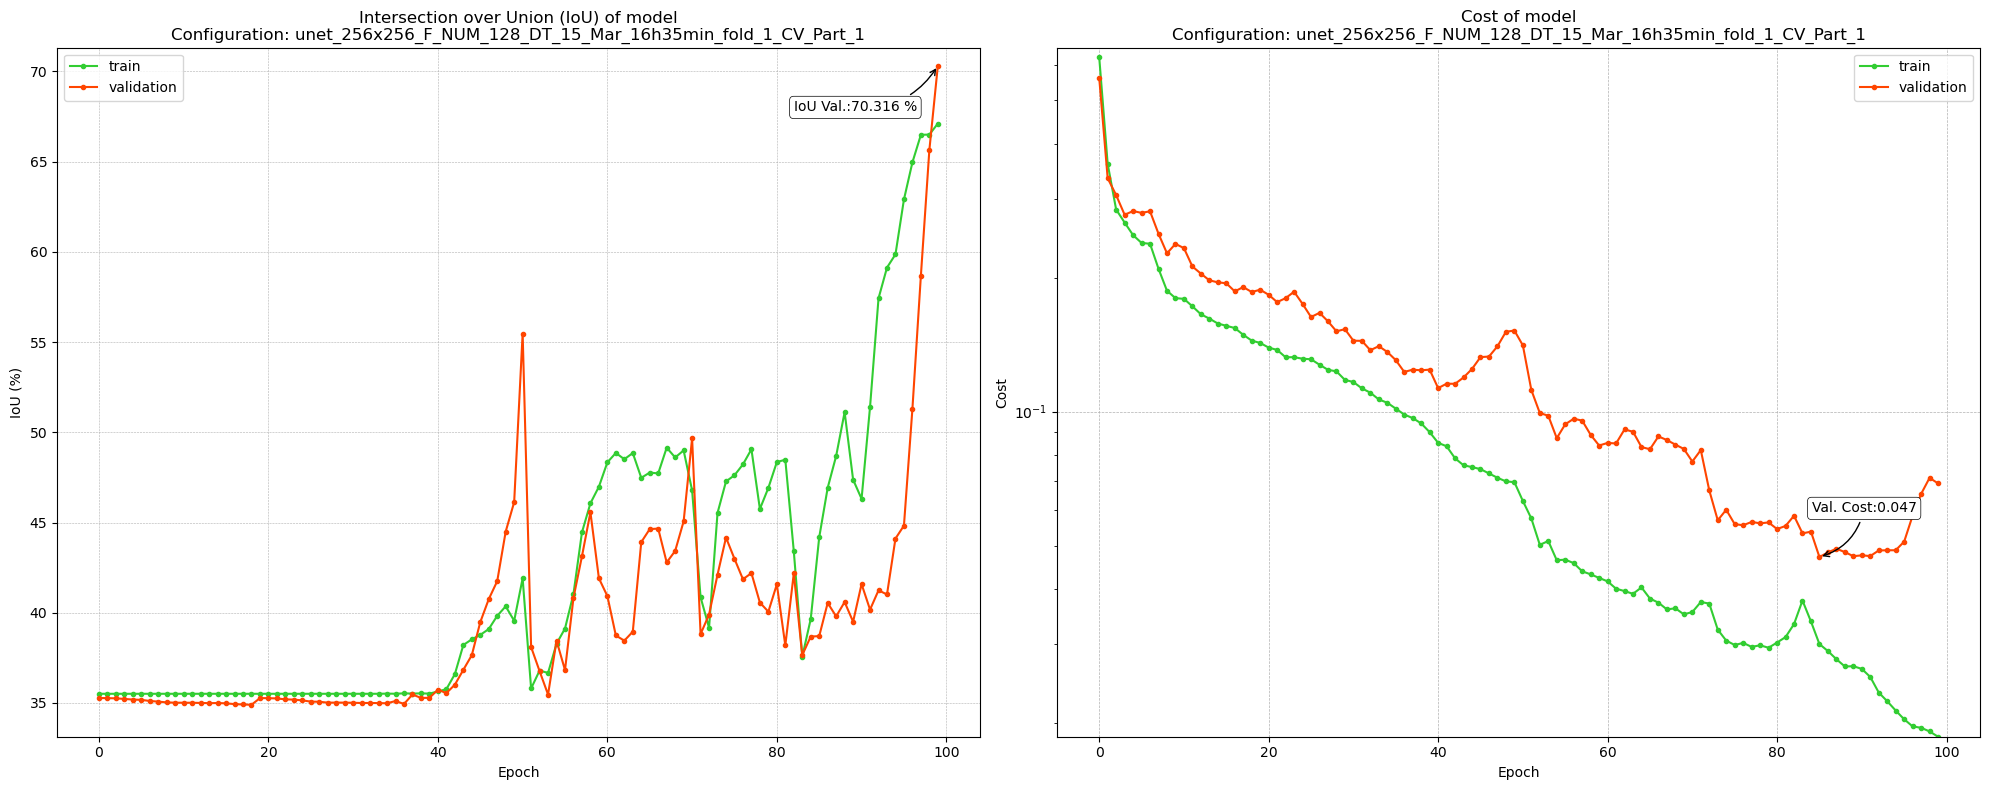

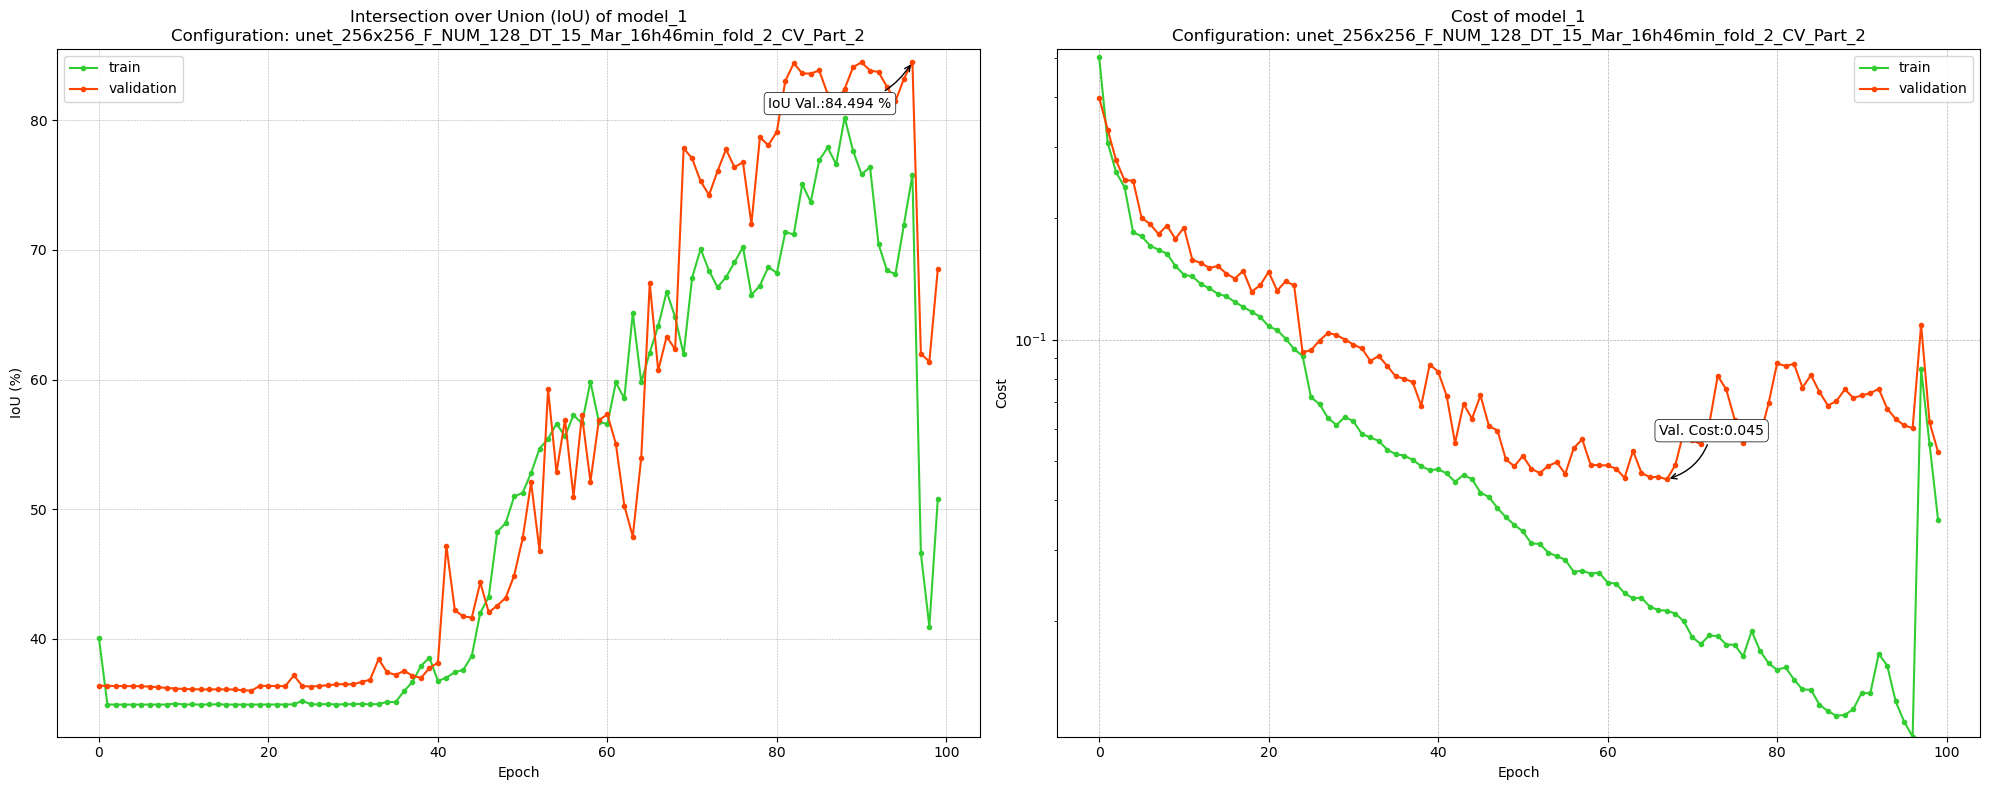

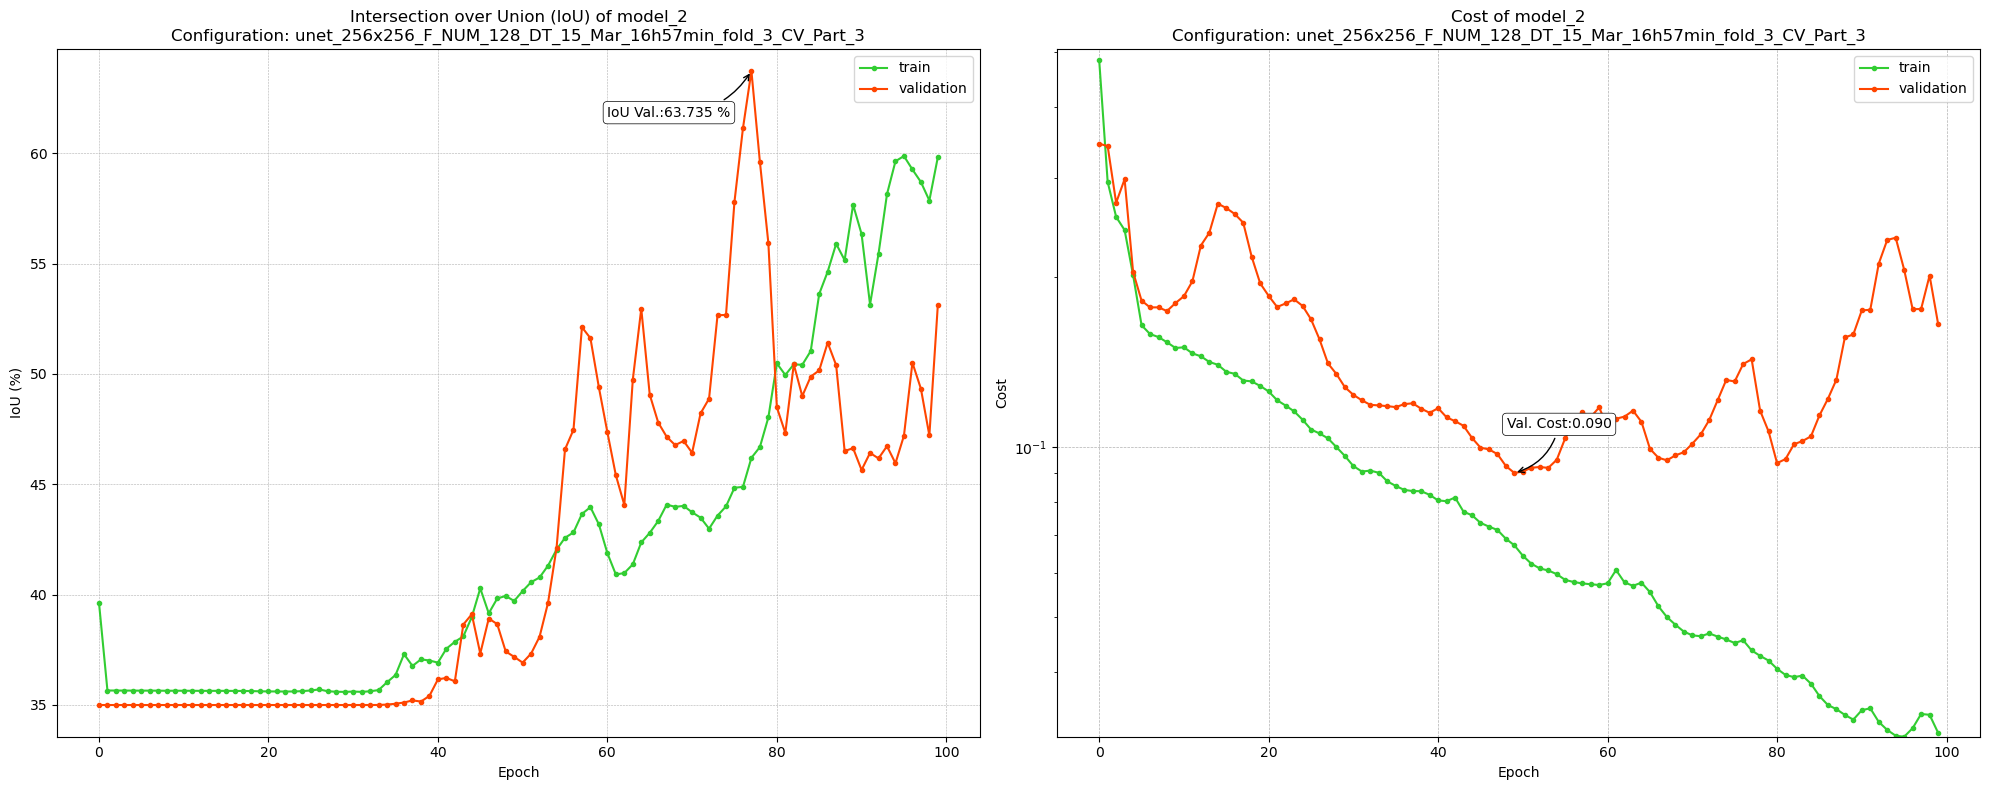

In [21]:
# Create a K-fold cross-validator with 3 splits, shuffling the data and using a fixed random state
k_part = KFold(n_splits=3, shuffle=True, random_state=CONFIGS['SEED'])
# Counter for current fold
fold_n = 1 
# Lists to store metric values and training histories for each fold
vc_scores, histories = list(), list()

# Clear any previously created models from memory
backend.clear_session()

# Create data generators for test set
generator_test = generate_batch([imgs_path_test, mscs_path_test], 
                                batch_size=CONFIGS["BATCH_SZ"])

# Loop through each fold
for tr_indices, val_indices in k_part.split(X=np.array(imgs_paths), y=np.array(msks_paths)):
    
    # Clear any previously created models from memory
    #backend.clear_session()
    
    # Create string run and callback functions
    str_run = create_run_string(model_name='unet',fold=fold_n, use_cross_val=True)
    print(str_run)
    cllbcks = callback_funcs(str_run, fold_n = fold_n)

    # Create data generators for training and validation sets
    generator_train = generate_batch([np.array(imgs_paths)[tr_indices], 
                                      np.array(msks_paths)[tr_indices]], 
                                      batch_size=CONFIGS["BATCH_SZ"])
    generator_valid = generate_batch([np.array(imgs_paths)[val_indices], 
                                      np.array(msks_paths)[val_indices]], 
                                      batch_size=CONFIGS["BATCH_SZ"])
    
    # Create and compile the U-Net model
    model = None
    model = create_UNET(img_dim= (CONFIGS['H'], CONFIGS['W']), 
                        ref_filters=CONFIGS['REF_FILTERS'], 
                        batch_sz=CONFIGS['BATCH_SZ'])
    
    model.compile(optimizer=CONFIGS['OPTIMIZER'], 
                  loss='binary_crossentropy', 
                  metrics=CONFIGS['METRICS'])
    
    # Train the model
    history = model.fit(generator_train,
                        validation_data=generator_valid,
                        epochs=CONFIGS['EPOCHS'],
                        batch_size=CONFIGS['BATCH_SZ'],
                        verbose=1,
                        steps_per_epoch=len(tr_indices) // CONFIGS['BATCH_SZ'],
                        validation_steps=len(val_indices) // CONFIGS['BATCH_SZ'],
                        validation_batch_size=CONFIGS['BATCH_SZ'],
                        callbacks=cllbcks)
    
    # Visualize the fold training history
    metrics_graphs(history, model=model, 
                   model_conf=str_run + '_CV_Part_' + str(fold_n), iou=True,
                   y_log=True)
    
    # Evaluate the model on training, validation, and test sets and print metrics
    score = model.evaluate(generator_train, 
                           steps=len(imgs_path_test) // CONFIGS['BATCH_SZ'], 
                           verbose=0)
    print(f'Training Metrics\n IoU = {round(score[1], 4)*100} %\
          \n Precision = {round(score[2], 4)*100} %\
          \n Recall = {round(score[3], 4)*100} %')
    
    score = model.evaluate(generator_valid, 
                           steps=len(val_indices) // CONFIGS['BATCH_SZ'], 
                           verbose=0)
    print(f'Validation Metrics\n IoU = {round(score[1], 4)*100} %\
          \n Precision = {round(score[2], 4)*100} %\
          \n Recall = {round(score[3], 4)*100} %')
    score = model.evaluate(generator_test, 
                           steps = len(imgs_path_test) // CONFIGS['BATCH_SZ'], 
                           verbose = 0)
    print(f'Test Metrics\n IoU = {round(score[1], 4)*100} %\
           \n Precision = {round(score[2], 4)*100} % \
           \n Recall = {round(score[3], 4)*100} %')


    # concatenate the scores and histories for each fold
    vc_scores.append(score)
    histories.append(history)
    fold_n += 1

    # redifines learning rate
    lr_atual = model.optimizer.lr.read_value()
    if lr_atual != 0.001:
        print(f'After fold training, learning rate reposition from {lr_atual} to 0,001')
        model.optimizer.lr.assign(0.001)

print(f"Cross Valid. average: IoU = {round(np.mean(vc_scores[0])*100, 2)}% Precision = {round(np.mean(vc_scores[1])*100, 2)}% Recall = {round(np.mean(vc_scores[2])*100, 2)}%")
print(f"Cross Valid. std: IoU = {round(np.std(vc_scores[0]*100), 2)}% Precision = {round(np.std(vc_scores[1])*100, 2)}% Recall = {round(np.std(vc_scores[2])*100, 2)}%")
